<a href="https://colab.research.google.com/github/zeulsoare/Licenta-2019-2020/blob/master/Licenta_CNN_Good.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, LabelEncoder
import math
import statistics

dataset_url = 'https://raw.githubusercontent.com/zeulsoare/Licenta-2019-2020/master/dataset/processed-data/processed-mental-states.csv'
data = pd.read_csv(dataset_url)

TensorFlow 2.x selected.


In [0]:
# Split columns as features and class
X = data.iloc[:,0:-1] # features
Y = data.iloc[:,-1] # target class
img_size = tf.constant([20,20])

# Modify X to be >= 0 (needed in chi2 algorithm)
# Add global min for every data entry
global_min = X.min().min()
X = pd.DataFrame([X[col] + abs(global_min) for col in X.columns]).T

# Select best feature using chi2 algorithm
num_features = img_size.numpy()[0]*img_size.numpy()[1]

bestFeatures = SelectKBest(score_func=chi2,k=num_features)
fit = bestFeatures.fit(X,Y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Features', 'Score']

# Select the top 256 (16 x 16 image matrix dimensions) features, Score >= 10
top_features = pd.DataFrame(featureScores.nlargest(num_features,'Score'))
X = X.filter(top_features.Features,axis=1)

# Substract global min again to the data, to restore it after feature selection
X = pd.DataFrame([X[col] - abs(global_min) for col in X.columns]).T

In [0]:
# Normalize X so we can use the data as a grayscale image
X_norm = X.values
# I should try multiple methods of normalization to see if they matter on training
# 1. MaxAbsScaler
# 2. MinMaxScaler
scaler = MaxAbsScaler(copy=False)
#scaler = MinMaxScaler(copy=False)
X_norm = scaler.fit_transform(X_norm)
X.loc[:,:] = X_norm

# One Hot Encod labels for use in CCE
Y = keras.utils.to_categorical(Y.values,num_classes=3)

# Split dataset into train and test (70% train and 30% test)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size=0.7)

X_train = tf.reshape(X_train.values,[-1,img_size.numpy()[0],img_size.numpy()[1],1])
X_test = tf.reshape(X_test.values,[-1,img_size.numpy()[0],img_size.numpy()[1],1])


Y_train = Y_train
Y_test = Y_test

In [0]:
def MindStateNet(X,Y,img_size):
    # Using this model I got the following results on a 20x20x1 image
    # Epoch taken : 239
    # Overall loss : 0.1346
    # Overall accuracy : 0.9481
    # Overall validation loss : 0.3272
    # Overall validation accuracy : 0.8930
    # Model was trained using default Adam optimizer with CCE loss function
    # 128 batch size with 0.15 validation split on 350 epoch with an early stopping
    # on val_loss

    inputs = keras.Input(shape=(20,20,1))

    x = keras.layers.Conv2D(32,(3,3),padding='same',activation='relu')(inputs)
    x = keras.layers.Conv2D(64,(2,2),activation='relu')(x)
    x = keras.layers.MaxPool2D()(x)
    x = keras.layers.Dropout(0.4)(x)

    x = keras.layers.Conv2D(128,(2,2),activation='relu')(x)
    x = keras.layers.MaxPool2D()(x)
    x = keras.layers.Dropout(0.5)(x)

    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256,activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(3,activation='softmax')(x)

    model = keras.Model(inputs, x) 
    #keras.utils.plot_model(model,show_shapes=True)
    #model.summary()
    model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])
    patience_epoch = 50
    history = model.fit(X, Y, 128, 350, validation_split=0.15,callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience_epoch,verbose=1,restore_best_weights=False)])

    return model, history, patience_epoch

In [5]:
model, history, patience_epoch = MindStateNet(X_train,Y_train,img_size)

Train on 1699 samples, validate on 300 samples
Epoch 1/350
1699/1699 [==============================] - 7s 4ms/sample - loss: 1.0636 - accuracy: 0.3720 - val_loss: 1.0243 - val_accuracy: 0.4700
Epoch 2/350
1699/1699 [==============================] - 0s 60us/sample - loss: 1.0235 - accuracy: 0.4461 - val_loss: 1.0053 - val_accuracy: 0.4267
Epoch 3/350
1699/1699 [==============================] - 0s 67us/sample - loss: 1.0105 - accuracy: 0.4579 - val_loss: 0.9926 - val_accuracy: 0.4367
Epoch 4/350
1699/1699 [==============================] - 0s 59us/sample - loss: 1.0003 - accuracy: 0.4679 - val_loss: 0.9996 - val_accuracy: 0.4433
Epoch 5/350
1699/1699 [==============================] - 0s 61us/sample - loss: 0.9973 - accuracy: 0.4879 - val_loss: 0.9772 - val_accuracy: 0.5100
Epoch 6/350
1699/1699 [==============================] - 0s 59us/sample - loss: 0.9821 - accuracy: 0.5197 - val_loss: 0.9753 - val_accuracy: 0.5033
Epoch 7/350
1699/1699 [==============================] - 0s 58us/s

In [6]:
print('Epoch taken : %d' %(history.epoch[-1]+1))
print('Overall loss : %.4f' %statistics.mean(history.history['loss'][-patience_epoch:]))
print('Overall accuracy : %.4f' %statistics.mean(history.history['accuracy'][-patience_epoch:]))
print('Overall validation loss : %.4f' %statistics.mean(history.history['val_loss'][-patience_epoch:]))
print('Overall validation accuracy : %.4f' %statistics.mean(history.history['val_accuracy'][-patience_epoch:]))

Epoch taken : 160
Overall loss : 0.1918
Overall accuracy : 0.9246
Overall validation loss : 0.3963
Overall validation accuracy : 0.8441


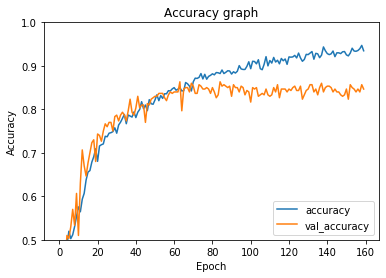

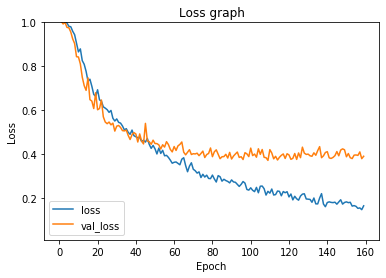

In [7]:
# Evaluating the model through graphs
plt.title('Accuracy graph')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

plt.title('Loss graph')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.009, 1])
plt.legend(loc='lower left')
plt.show()

In [8]:
# Test model on test dataset
results = model.evaluate(X_test, Y_test)
predictions = model.predict(X_test)

# Transform data from one hot to normal labels
true_class_pred = np.argmax(predictions,axis=1)
true_class = np.argmax(Y_test,axis=1)

857/857 [==============================] - 0s 128us/sample - loss: 0.4018 - accuracy: 0.8681


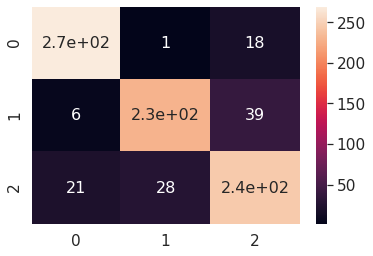

In [9]:
import seaborn as sn
from sklearn import metrics
cm = metrics.confusion_matrix(true_class, true_class_pred)
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()